# Исследование предпочтений пользователей и изменений в сервисе для покупки билетов Яндекс.Афиша

Сервис Яндекс.Афиша в лице сотрудников отдела продукта обратился с запросом для исследования потребительских предпочтений перед сезоном мероприятий и праздников (ноябрь-декабрь 2024г.). 

**Цель исследования:** отследить тренды в изменении потребительского спроса и подготовить ключевые рекомендации для успешного проведения сезона праздников. 

**Задачи исследования:** 
- изучить, какие факторы влияют на изменение потребительского спроса
- определить наиболее востребованные категории мероприятий, выявить перспективные для осенне-зимнего сезона категории
- определить, какие партнеры и регионы приносят большую долю выручки, выявить потенциал для роста
- выявить отличия между пользователями десктопных и мобильных устройств, определить их паттерн в отношении покупок билетов

**Содержание проекта:**

1. Знакомство с данными
2. Предобработка данных  
    2.1. Проверка на пропуски  
    2.2. Проверка корректности категориальных данных и поиск аномалий  
    2.3. Проверка на явные и неявные дубли  
    2.4. Преобразование и оптимизация типов данных  
    2.5. Создание новых столбцов
3. Исследовательский анализ данных  
    3.1. Анализ распределения заказов по сегментам и их сезонные изменения  
    3.2. Осенняя активность пользователей  
    3.3. Популярные события и партнёры
4. Статистический анализ данных  
    4.1. Проверка гипотезы о равенстве среднего количества заказов различных устройств  
    4.2. Проверка гипотезы о равенстве среднего времени между заказами различных устройств
5. Итоговый вывод и рекомендации

## Знакомство с данными

Для начала импортируем библиотеки для работы с данными и визуализации, а также для проведения статистического анализа. Загрузим все датасеты в переменные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import mannwhitneyu
import warnings 
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
df_orders = pd.read_csv('https://code.s3')
df_events = pd.read_csv('https://code.s3')
df_kzt =  pd.read_csv('https://code.s3')

Посмотрим на данные, проверим, соответствуют ли они описанию, какие есть проблемы в данных, предварительно определим, что необходимо сделать на этапе предобработки

In [3]:
display(df_orders.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [4]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

Всего в датафрейме **290 849** строк и **14** столбцов. Все столбцы, кроме `days_since_prev`, без пропусков, что не потребует дальнейшей обработки. Столбец `days_since_prev` не заполняем, так как понятна закономерность для появления пропусков (это первая покупка у этого пользователя). Столбец `created_dt_msk` не приведен к типу даты, `days_since_prev` представлен в виде числа с плавающей точкой, что тоже странно, больше подойдет `integer`. Остальные числовые столбцы можно оптимизировать (уменьшим разрядность). Так в общем данные соответствуют описанию.

Переходим к следующему датафрейму:

In [5]:
display(df_events.head())

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [6]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


В таблице **22 427** строк и **11** столбцов. В столбцах нет пропусков. Все типы данных корректные. Возможно следует сделать также оптимизацию числовых данных. Данные соответствуют описанию.

Переходим к последнему, больше справочному датасету: 

In [7]:
display(df_kzt.head())

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [8]:
df_kzt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Представлены данные за 2024ый год по колебаниям курса валюты. В этой таблице, как и предполагалось, нет особо никаких проблем - только нужно будет изменить тип данных у столбца с датой и также оптимизировать числовые столбцы. Данные тоже соответствуют описанию. 

**Общие рекомендации для каждого датафрейма:**
- `df_orders` - изменить типы данных у столбцов, оптимизировать числовые столбцы, дополнительно проверить категориальные данные, корректность их написания
- `df_events` - оптимизировать числовые столбцы, дополнительно проверить категориальные данные, корректность их написания
- `df_kzt` - изменить тип данных у столбца с датой, оптимизировать числовые столбцы

Также каждый датафрейм пройдет проверку на дубли (явные и неявные), анализ количественных столбцов для выявления аномалий и выбросов. Рассчитаны дополнительные показатели и категорийные столбцы для последующего анализа.

## Предобработка данных

### Проверка на пропуски

Для более удобной предобработки объединим два датафрейма `df_orders` и `df_events`

In [9]:
df = df_orders.merge(df_events, on='event_id')

Посмотрим на количество строк в результатирующем датафрейме и сравним его с количеством строк в датафрейме с заказами (так как он был самым многочисленным по данным):

In [10]:
print(f'В изначальном датафрейме с заказами - {df_orders.shape[0]} строк')
print(f'В финальном датафрейме - {df.shape[0]} строк')
print(f'Разница составляет {df_orders.shape[0] - df.shape[0]} строк')
print(f'Доля утерянных строк - {(df_orders.shape[0] - df.shape[0]) / df_orders.shape[0]:.2%}')

lost_revenue = df_orders['revenue'].sum() - df['revenue'].sum()
print(f'Потерянная выручка составила - {lost_revenue:.2f}')

В изначальном датафрейме с заказами - 290849 строк
В финальном датафрейме - 290611 строк
Разница составляет 238 строк
Доля утерянных строк - 0.08%
Потерянная выручка составила - 3084.81


Доля строк, которые были потеряны при объединении двух датафреймов невелика - меньше 0,1%. Более того, утерянная выручка составила около 3100 рублей, что также некритично для общей суммы. Переходим к проверке категориальных данных

### Проверка корректности категориальных данных и поиск аномалий

В итоговом датафрейме для проверки корректности категориальных данных нас интересует 9 столбцов: `cinema_curcuit`, `currency_code`, `device_type_canonnical`, `service_name`, `event_type_description`, `event_type_main`, `region_name`, `city_name`, `venue_name`. Для начала оценим, сколько уникальных значений в каждом столбце:

In [11]:
for col in ['cinema_circuit', 'currency_code', 'device_type_canonical', 
            'service_name', 'event_type_description', 'event_type_main',
            'region_name', 'city_name', 'venue_name']:
    unique_values = df[col].nunique()
    print(f'В столбце {col} - {unique_values} уникальных категориальных значений')

В столбце cinema_circuit - 6 уникальных категориальных значений
В столбце currency_code - 2 уникальных категориальных значений
В столбце device_type_canonical - 2 уникальных категориальных значений
В столбце service_name - 36 уникальных категориальных значений
В столбце event_type_description - 20 уникальных категориальных значений
В столбце event_type_main - 7 уникальных категориальных значений
В столбце region_name - 81 уникальных категориальных значений
В столбце city_name - 352 уникальных категориальных значений
В столбце venue_name - 3217 уникальных категориальных значений


После оценки количества уникальных значений в этих столбцах, можно определиться со стратегией проверки корректности категориальных значений. Для столбцов `region_name`, `city_name`, `venue_name` напишем функцию для сравнения количества уникальных значений до и после нормализации и итоговым вердиктом, нужна ли нормализация в итоговом датафрейме. Для остальных будет достаточно группировки

In [48]:
for col in ['cinema_circuit', 'currency_code', 'device_type_canonical', 
            'service_name', 'event_type_description', 'event_type_main']:
    display(df.groupby(col, as_index=False)['order_id'].count().sort_values(by='order_id', ascending=False))

,cinema_circuit,order_id
5,нет,289213
0,Другое,1261
1,КиноСити,122
2,Киномакс,7
3,Москино,7
4,ЦентрФильм,1


,currency_code,order_id
1,rub,285542
0,kzt,5069


,device_type_canonical,order_id
1,mobile,232490
0,desktop,58121


,service_name,order_id
3,Билеты без проблем,63519
21,Лови билет!,41124
5,Билеты в руки,40343
24,Мой билет,34839
25,Облачко,26642
22,Лучшие билеты,17774
8,Весь в билетах,16849
26,Прачечная,10273
19,Край билетов,6207
30,Тебе билет!,5228


,event_type_description,order_id
2,концерт,112049
11,событие,58605
12,спектакль,50592
17,шоу,13626
13,спорт,12837
5,мюзикл,9919
14,спортивное мероприятие,9074
0,балет,5998
1,выставка,5876
16,цирковое шоу,5327


,event_type_main,order_id
2,концерты,115276
5,театр,67321
1,другое,65867
3,спорт,21911
4,стендап,13393
0,выставки,4854
6,ёлки,1989


В целом можно сказать, что с категориями в этих столбцах все в порядке, с некоторыми заметками по поводу `event_type_description` и `event_type_main` - значения "событие" и "другое" имеют достаточно много заказов на счету, но сами эти значения не дают никакой информации. Получается, что большой пласт заказов не дает нам какой-либо идентификации по этим столбцам. Следует передать это команде продукта.

Теперь напишем функцию для просмотра большого количества категориальных данных:

In [13]:
def normalize(df, col):
    ''' 
    Функция получает на вход:
    - df - датафрейм, в котором нужно провести проверку, нужна ли нормализация
    - col - столбец,  в котором нужно провести проверку, нужна ли нормализация
    Функция подсчитывает число уникальных значений до и после нормализации, а далее
    возвращает вердикт, сравнивая число уникальных значений в двух перечисленных случаях
    '''
    before_norm = df[col].nunique()
    after_norm = df[col].str.lower().str.strip().nunique()
    if before_norm > after_norm:
        return 'нормализация нужна'
    elif before_norm == after_norm:
        return 'нормализация не нужна'
    else:
        return 'даже не знаю, что тут нужно тогда...'

for col in ['region_name', 'city_name', 'venue_name']:
    print(f'Для столбца {col} {normalize(df, col)}')

Для столбца region_name нормализация не нужна
Для столбца city_name нормализация не нужна
Для столбца venue_name нормализация не нужна


Проверка проведена, можем двигаться дальше и рассмотреть количественные столбцы `revenue` и `tickets_count`. Посмотрим на распределение данных:

In [14]:
print(df['revenue'].describe(percentiles=[.8, .9, .95, .99]))
print(df['tickets_count'].describe(percentiles=[.8, .9, .95, .99]))

count    290611.000000
mean        625.584360
std        1227.693064
min         -90.760000
50%         356.010000
80%         950.100000
90%        1323.070000
95%        1744.990000
99%        4003.133000
max       81174.540000
Name: revenue, dtype: float64
count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
50%           3.000000
80%           4.000000
90%           4.000000
95%           5.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64


Видно, что в данных явно присутствуют выбросы - средние значительно отличаются от медианы, максимальные значения тоже заоблачные. Необходимо провести фильтрацию данных по 99ому перцентилю. Но следует это сделать в разрезе валюты. После этого построим диаграммы размаха, на которых уже будет лучше видно распределение

In [15]:
# вычисляем 99-й перцентиль по валюте
percentiles_revenue = df.groupby('currency_code').agg(p99=('revenue', lambda x: x.quantile(0.99))).reset_index()
percentiles_tickets = df['tickets_count'].quantile(0.99)

# для каждого значения выручки теперь будет свой 99ый перцентиль по валюте
df = df.merge(percentiles_revenue, on='currency_code', how='left')

# фильтрация
df_clean = df[df['revenue'] < df['p99']]
df_clean = df_clean[df['tickets_count'] < percentiles_tickets]

# проверка, сколько строк мы в итоге отфильтровали
print(f'Строк до фильтрации: {df.shape[0]}')
print(f'Строк после фильтрации: {df_clean.shape[0]}')

Строк до фильтрации: 290611
Строк после фильтрации: 283444


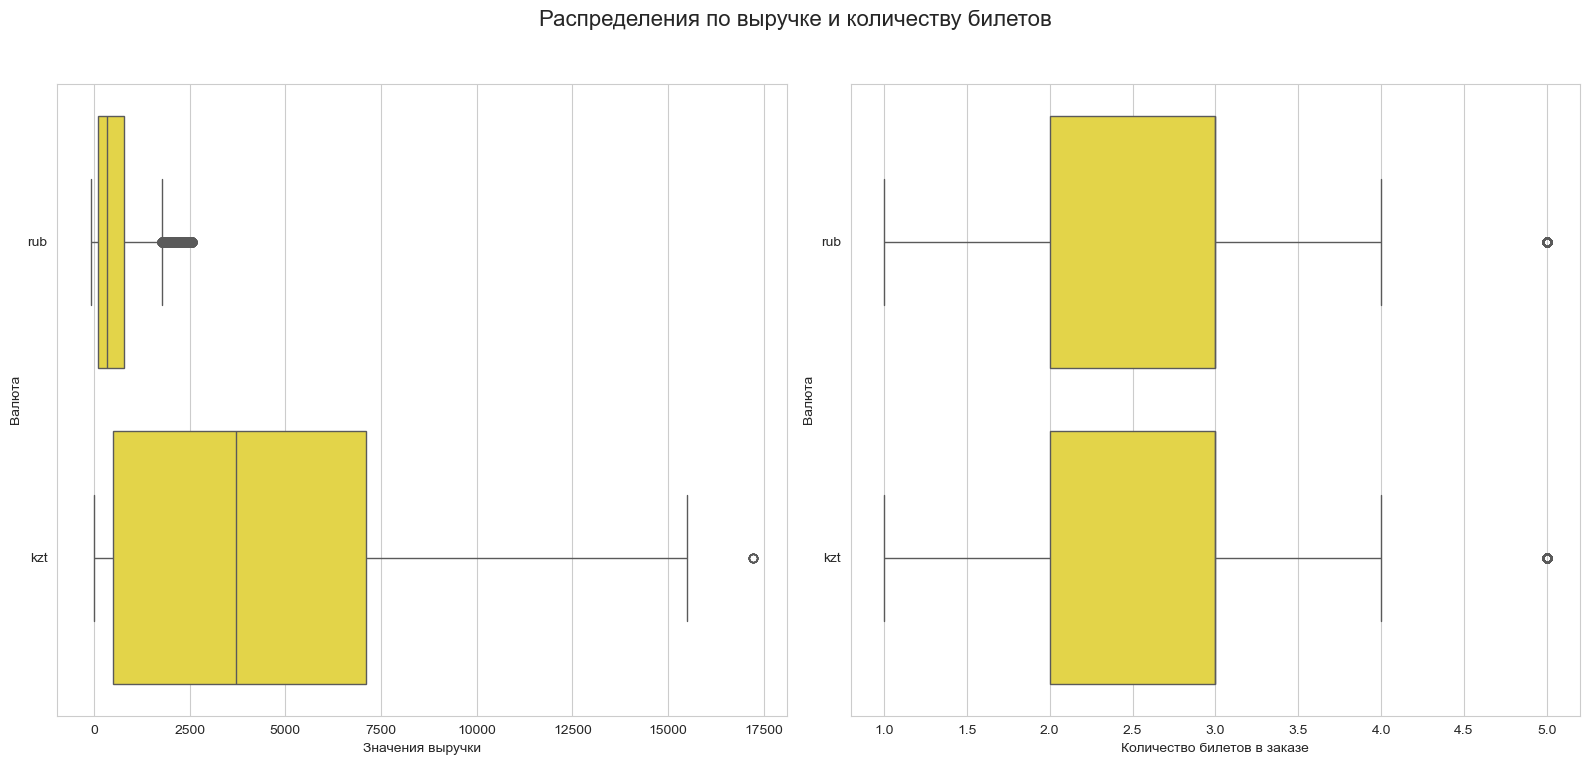

In [16]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(x=df_clean['revenue'], y=df_clean['currency_code'], ax=axes[0], color='#fce830')
sns.boxplot(x=df_clean['tickets_count'], y=df_clean['currency_code'], ax=axes[1], color='#fce830')

axes[0].set_xlabel('Значения выручки')
axes[0].set_ylabel('Валюта')

axes[1].set_xlabel('Количество билетов в заказе')
axes[1].set_ylabel('Валюта')

fig.suptitle('Распределения по выручке и количеству билетов',  fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Проверка на неявные и явные дубли

Для обработки дубликатов, используем метод `duplicated()` с параметром `subset`. Для этого определим, какие строки могут нам давать дубль без учета идентификатора заказа. Точно один и тот же клиент не может совершать заказ в одно и то же время, а также при одинаковой выручке с заказа (допускаю, что может быть генерация двух заказов, где отличается стоимость билетов). Попробуем поискать дубли именно по этому сочетанию столбцов.

In [17]:
df_clean.duplicated(subset=['user_id', 'created_ts_msk', 'revenue']).sum()

49

Таких дубля 49, посмотрим на них:

In [18]:
df_clean[df_clean.duplicated(subset=['user_id', 'created_ts_msk', 'revenue'], keep=False)].head(10)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,p99
11759,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,спектакль,театр,№1482,Светополянский округ,Глиноград,54,4443,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50",2570.8
11760,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,спектакль,театр,№1482,Светополянский округ,Глиноград,54,4443,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50",2570.8
12678,5593202,08199117318954f,2024-07-31,2024-07-31 11:52:06,553623,нет,18,rub,mobile,0.00,...,событие,другое,№4549,Каменевский регион,Глиногорск,213,3474,"Креативное пространство ""Вдох"" Лимитед","бул. Пригородный, д. 7/1",2570.8
12679,5592970,08199117318954f,2024-07-31,2024-07-31 11:52:06,553623,нет,18,rub,desktop,0.00,...,событие,другое,№4549,Каменевский регион,Глиногорск,213,3474,"Креативное пространство ""Вдох"" Лимитед","бул. Пригородный, д. 7/1",2570.8
26868,1930705,0dc525d7bacbb0d,2024-07-31,2024-07-31 13:26:11,393430,нет,18,rub,desktop,1556.05,...,концерт,концерты,№5048,Каменевский регион,Глиногорск,213,2704,"Летний фестиваль ""Симфония"" Лтд","бул. Боровой, д. 8/1 стр. 43",2570.8
26870,1930763,0dc525d7bacbb0d,2024-07-31,2024-07-31 13:26:11,393430,нет,18,rub,desktop,1556.05,...,концерт,концерты,№5048,Каменевский регион,Глиногорск,213,2704,"Летний фестиваль ""Симфония"" Лтд","бул. Боровой, д. 8/1 стр. 43",2570.8
51572,5378312,1f49b8de206b285,2024-10-01,2024-10-01 11:32:40,574431,нет,0,rub,desktop,155.99,...,спорт,спорт,№1531,Медовская область,Радужсвет,47,2157,"Студия дизайна ""Платформа"" Инкорпорэйтед","наб. Магистральная, д. 5",2570.8
51613,2968673,1f49b8de206b285,2024-10-01,2024-10-01 11:32:40,574431,нет,0,rub,mobile,155.99,...,спорт,спорт,№1531,Медовская область,Радужсвет,47,2157,"Студия дизайна ""Платформа"" Инкорпорэйтед","наб. Магистральная, д. 5",2570.8
53680,1935113,206ea45ec11d478,2024-10-29,2024-10-29 16:46:54,442183,нет,16,rub,mobile,601.69,...,концерт,концерты,№894,Каменевский регион,Глиногорск,213,4363,"Студия дизайна ""Лестница"" Лимитед","наб. Школьная, д. 9/8 стр. 7/5",2570.8
53682,1935171,206ea45ec11d478,2024-10-29,2024-10-29 16:46:54,442183,нет,16,rub,mobile,601.69,...,концерт,концерты,№894,Каменевский регион,Глиногорск,213,4363,"Студия дизайна ""Лестница"" Лимитед","наб. Школьная, д. 9/8 стр. 7/5",2570.8


Без учета идентификаторов заказа видно, что это полные дубли (за исключением тех, что были оформлены через другое устройство, хотя тоже странная ситуация - обычно пользователи не сидят с двух устройств и не делают заказ секунда в секунду), значит их необходимо удалить.

In [19]:
print(f'Строк до удаления неявных дублей - {df_clean.shape[0]}')

df_clean = df_clean.drop_duplicates(subset=['user_id', 'created_ts_msk', 'revenue'])

print(f'Строк после удаления неявных дублей - {df_clean.shape[0]}')

Строк до удаления неявных дублей - 283444
Строк после удаления неявных дублей - 283395


Теперь сделаем проверку на явные дубли, без выделения отдельных столбцов для проверки:

In [20]:
print(f'Явных дубликатов - {df_clean.duplicated().sum()}')

Явных дубликатов - 0


Дубликатов нет, удалять больше ничего не нужно

### Преобразование и оптимизация типов данных

Для начала переведем в нужный тип данных следующие столбцы: `days_since_prev`, `created_dt_msk`, `created_ts_msk`, `data`.

In [21]:
df_clean['days_since_prev'] = df_clean['days_since_prev'].astype('Int64')
df_clean['created_dt_msk'] = pd.to_datetime(df_clean['created_dt_msk'])
df_clean['created_ts_msk'] = pd.to_datetime(df_clean['created_ts_msk'])

df_kzt['data'] = pd.to_datetime(df_kzt['data'])

Далее уже с нужными типами данных проведем оптимизацию:

In [22]:
# сначала для столбцов с числами с плавающей точкой
for col in ['revenue', 'total']:
    df_clean[col] = pd.to_numeric(df_clean[col], downcast='float')

# далее для целочисленных столбцов
for col in ['order_id', 'event_id', 'age_limit', 'tickets_count', 'city_id', 'venue_id']:
    df_clean[col] = pd.to_numeric(df_clean[col], downcast='integer')

# отдельно для датафрейма df_kzt
df_kzt['nominal'] = pd.to_numeric(df_kzt['nominal'], downcast='integer')
df_kzt['curs'] = pd.to_numeric(df_kzt['curs'], downcast='float')

### Создание новых столбцов

В датафрейме есть заказы в валюте тенге. Для того, чтобы дальнейший анализ был корректен, создадим столбец с переведенной в рубли выручкой:

In [23]:
# соединяем нужные данные с итоговым датафреймом
df_clean = df_clean.merge(df_kzt, how='left', left_on=['created_dt_msk', 'currency_code'], right_on=['data', 'cdx'])

# делим курс, чтобы посчитать выручку в рублях
df_clean['curs'] = df_clean['curs'] / 100
df_clean['revenue_rub'] = df_clean.apply(
    lambda row: row['revenue'] * row['curs'] if row['currency_code'] == 'kzt' else row['revenue'],
    axis=1
)

Также необходимо рассчитать стоимость за один билет, после того, как перевода выручку в рубли, это не составит труда:

In [24]:
df_clean['one_ticket_revenue_rub'] = df_clean['revenue_rub'] / df_clean['tickets_count']

Для различных агрегаций и группировок, анализа сезонности могут пригодится столбцы с месяцем и сезоном:

In [25]:
df_clean['month'] = df_clean['created_dt_msk'].dt.month

In [26]:
def season(month):
    '''
    Функция получает на вход номер месяца, а на выходе
    отдает название сезона, к которому относится месяц
    '''
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

df_clean['season'] = df_clean['month'].apply(season)

**Промежуточные выводы по предобработке данных**

- В результате объединения двух основных датафреймов у 238 заказов не нашлось информации по мероприятиям, что составляло меньше 0,1%, а также выручка в этих строках была незначительной (примерно 3100 рублей);
- Категорийные данные были корректны, не было неявных дублей вследствие разного написания значений, но точно в двух столбцах есть некоторая проблема в категоризации - `event_type_description` и `event_type_main` имеют значения "событие" и "другое", что не дает нам информации для анализа, имеет смысл передать это команде продукта Яндекс.Афиша для подробной конкретизации;
- В столбцах `revenue` и `tickets_count` были обнаружены аномалии, произведена фильтрация по 99ому перцентилю (для рублей это 2570,8, для тенге - 17617,24, а для билетов - 6), в результате фильтрации в датафрейме осталось 283 444 строки;
- Проверка на неявные дубликаты выявила 49 дубликатов - у них совпадали время заказа, идентификатор пользователя и сумма заказа (с различными суммами заказа дублей было 164, но допущение в приобретении разных билетов в одном заказе и одним пользователем принято к сведению), они были удалены. Проверка на явные дубли не обнаружила дубликатов, в результатирующем датафрейме осталось 283 395 строк;
- Столбцы с неподходящими типами данных приведены к типам данных соответствующим их природе, а также оптимизированы все столбцы с числовыми типами данных;
- Созданы новые столбцы, которые в дальнейшем упростят анализ и агрегацию данных: выручка в рублях, стоимость одного билета, месяц заказа, сезон заказа.

После фильтрации и очистки данных в датафрейме осталось 283 395 строк, сокращение данных составило 2,5%.

## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

Для начала посмотрим на общую динамику заказов по месяцам:

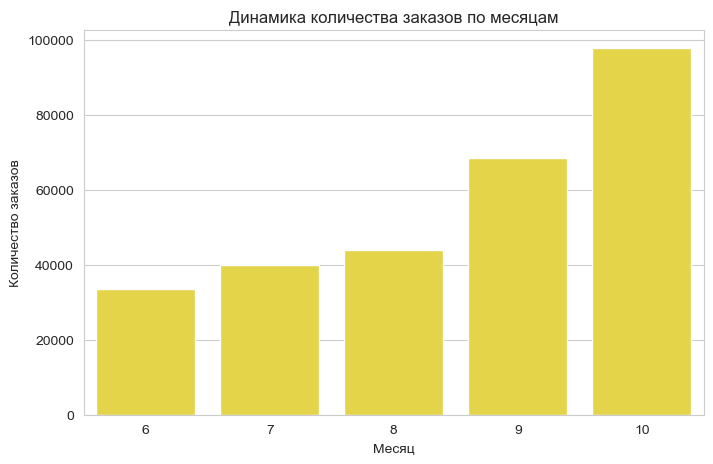

In [27]:
plt.figure(figsize=(8, 5))

sns.countplot(df_clean, x='month', color='#fce830')

plt.title('Динамика количества заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

In [28]:
monthly_dynamics = df_clean.groupby('month', as_index=False)['order_id'].count()
ratio = monthly_dynamics[monthly_dynamics['month'] == 10]['order_id'].values[0] / monthly_dynamics[monthly_dynamics['month'] == 6]['order_id'].values[0] - 1
print(f'Разница в заказах июня и октября 2024 - {ratio:.2%}')

Разница в заказах июня и октября 2024 - 190.98%


По графику и рассчитанным значениям видно, что увеличение заказов в октябре значительно - почти в два раза. Посмотрим теперь на распределение заказов по типам мероприятия, типу устройства, возрастному рейтингу. Предварительно нам необходимо посчитать долю каждого категориального значения, чтобы при увеличении заказов в целом по сезону мы видели, что рост обусловлен именно тем, что растет конкретная категория.

In [29]:
def share_plot(df, column, title, xlabel):
    '''
    Функция принимает на вход:
    - df - датафрейм, где находятся нужные данные
    - column - столбец, по которому мы хотим посмотреть распределение в долях
    - title - название графика
    - xlabel - подпись для оси X
    Функция предварительно подготавливает данные для графика: считает
    доли нужных категорий по сезонам и выводит получившийся датафрейм, а далее строит столбчатую диаграмму
    '''
    # предварительная подготовка данных
    event_share = df.groupby(['season', column], as_index=False)['order_id'].count()
    event_share.rename(columns={'order_id': 'count'}, inplace=True)
    event_share['total'] = event_share.groupby('season')['count'].transform('sum')
    event_share['share'] = event_share['count'] / event_share['total']
    display(event_share)

    # построение графика
    plt.figure(figsize=(12, 6))

    sns.barplot(event_share, x=column, y='share', hue='season', palette={'лето': '#fce830', 'осень': '#f2762e'})

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Доля заказов')
    plt.legend(title='Сезон')
    plt.grid(True)
    plt.show()

,season,event_type_main,count,total,share
0,лето,выставки,2401,117332,0.020463
1,лето,другое,31705,117332,0.270216
2,лето,концерты,50150,117332,0.427420
3,лето,спорт,2923,117332,0.024912
4,лето,стендап,6221,117332,0.053020
5,лето,театр,23664,117332,0.201684
6,лето,ёлки,268,117332,0.002284
7,осень,выставки,2423,166063,0.014591
8,осень,другое,32563,166063,0.196088
9,осень,концерты,62132,166063,0.374147


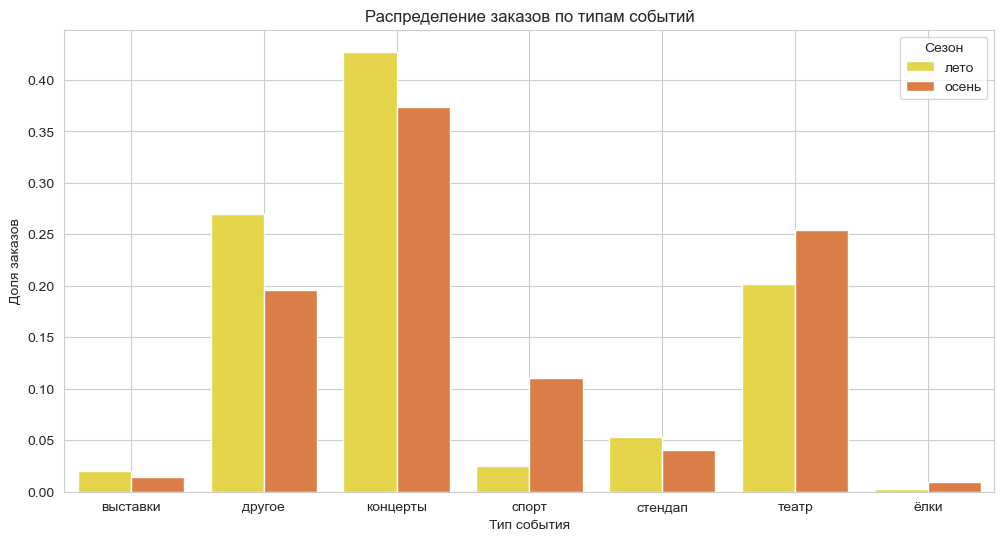

In [30]:
share_plot(df_clean, 'event_type_main', 'Распределение заказов по типам событий', 'Тип события')

По графику видно, что рост есть в следующих типах событий: спорт почти на 8%, театр почти на 6%, елки всего лишь на 0,7%, но тренд явно прослеживается. Посмотрим теперь на распределение по типу устройства

,season,device_type_canonical,count,total,share
0,лето,desktop,22644,117332,0.192991
1,лето,mobile,94688,117332,0.807009
2,осень,desktop,33635,166063,0.202544
3,осень,mobile,132428,166063,0.797456


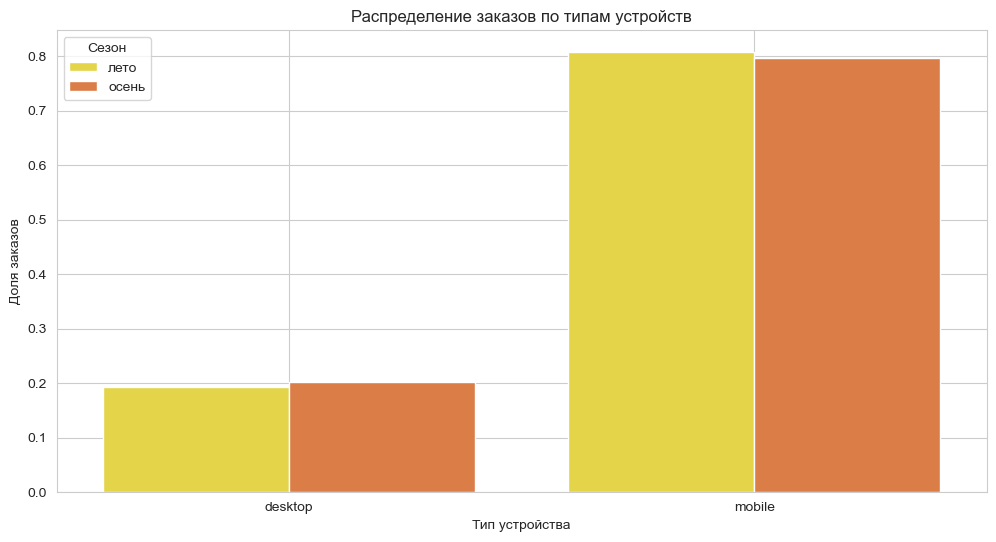

In [31]:
share_plot(df_clean, 'device_type_canonical', 'Распределение заказов по типам устройств', 'Тип устройства')

Видно очень незначительное увеличение доли заказов со стационарных устройств

,season,age_limit,count,total,share
0,лето,0,20870,117332,0.177871
1,лето,6,21400,117332,0.182388
2,лето,12,24020,117332,0.204718
3,лето,16,33547,117332,0.285915
4,лето,18,17495,117332,0.149107
5,осень,0,38873,166063,0.234086
6,осень,6,29233,166063,0.176036
7,осень,12,36748,166063,0.221290
8,осень,16,43940,166063,0.264598
9,осень,18,17269,166063,0.103991


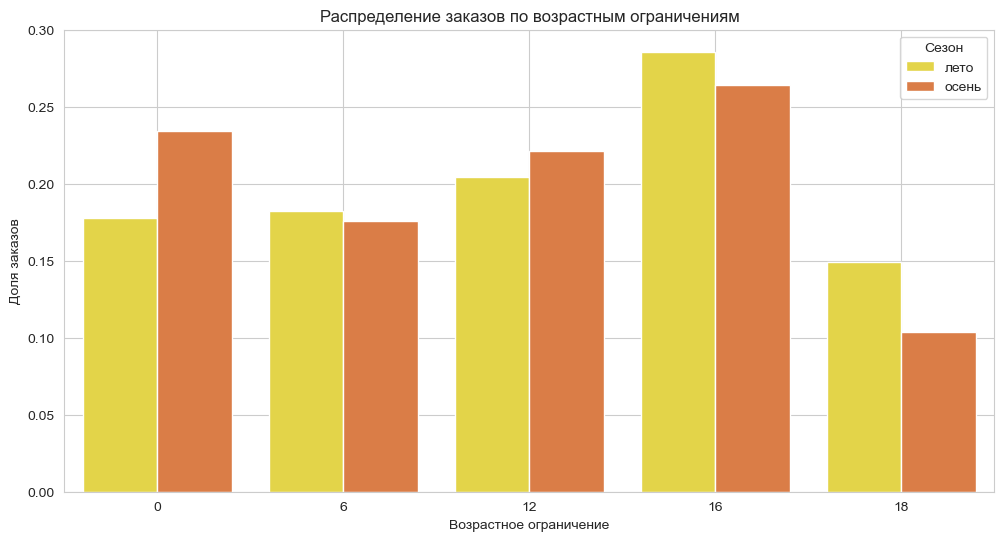

In [32]:
share_plot(df_clean, 'age_limit', 'Распределение заказов по возрастным ограничениям', 'Возрастное ограничение')

Видно увеличение категории "0+" - как раз скорее всего это тренд на увеличение покупок билетов на елки, небольшое увеличение заметно также в категории "12+" остальные возрастные ограничения наоборот уменьшились в своих долях. Возможно также это обусловлено тем, что дети вернулись от бабушек и дедушек и родители организовывают досуг для детей, приобретая различные билеты на мероприятия.

Теперь же рассмотрим выручку с одного билета, как она меняется с течением времени и сезоном.

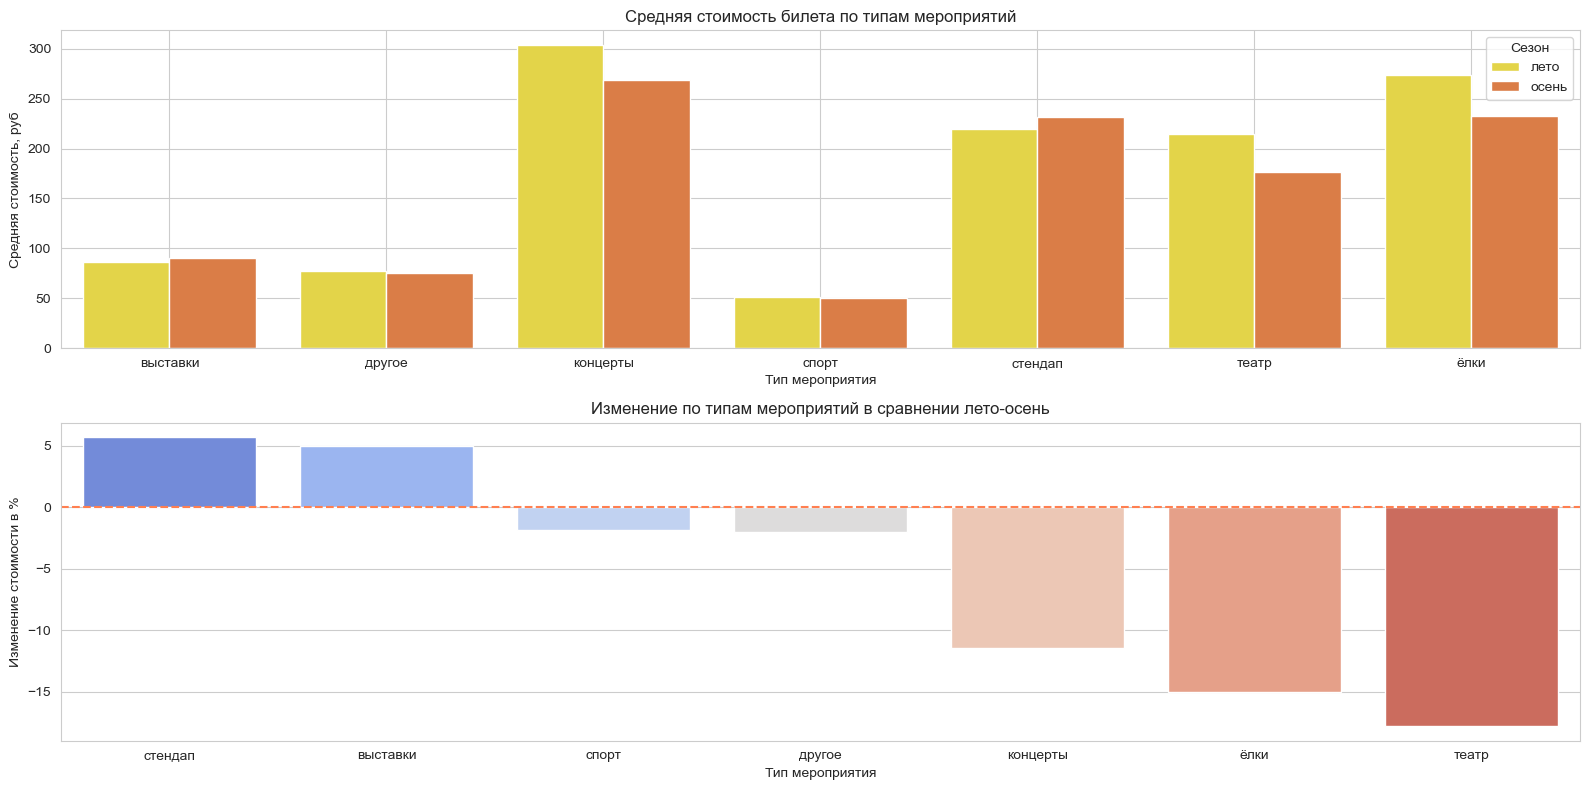

In [33]:
# посчитаем относительное изменение средней стоимости билета
seasonal_dynamics = df_clean.pivot_table(index='event_type_main', columns='season', values='one_ticket_revenue_rub', aggfunc='mean')
seasonal_dynamics['ratio'] = (seasonal_dynamics['осень'] / seasonal_dynamics['лето'] - 1) * 100

seasonal_dynamics_plot = df_clean.groupby(['event_type_main', 'season'], as_index=False)['one_ticket_revenue_rub'].mean()

# построим визуализацию
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
sns.barplot(seasonal_dynamics_plot, 
                    x='event_type_main', 
                    y='one_ticket_revenue_rub', 
                    hue='season', 
                    palette={'лето': '#fce830', 'осень': '#f2762e'}
           )
plt.title('Средняя стоимость билета по типам мероприятий')
plt.ylabel('Средняя стоимость, руб')
plt.xlabel('Тип мероприятия')
plt.legend(title='Сезон')
plt.grid(True)

plt.subplot(2, 1, 2)
sns.barplot(
    seasonal_dynamics.sort_values('ratio', ascending=False),
    x='event_type_main',
    y='ratio',
    palette='coolwarm'
)
plt.title('Изменение по типам мероприятий в сравнении лето-осень')
plt.ylabel('Изменение стоимости в %')
plt.axhline(0, color='#FF7F50', linestyle='--')
plt.xlabel('Тип мероприятия')

plt.tight_layout()
plt.show()

Практически все типы событий показали уменьшение среднего чека - тут может быть несколько причин, либо сами потребители делают выбор в пользу более дешевых билетов, либо же сам площадка проводит промоакции в придверии праздников и различных мероприятий. Только стэндап и выставки показали незначительное увеличение средней стоимости одного билета.

### Осенняя активность пользователей

Теперь рассмотрим показатели для осеннего периода, как периода, который наиболее релевантно будет отражать текущую картину и станет основой для рекомендация для периода ноябрь-декабрь 2024

In [34]:
# отберем только осенние заказы
df_autumn = df_clean[df_clean['season'] == 'осень']

# сгруппируем данные по датам, чтобы оценить динамику по показателям
df_autumn_grouped = df_autumn.groupby('created_dt_msk', as_index=False).agg(
    orders=('order_id', 'count'),
    dau=('user_id', 'nunique'),
    total_revenue=('revenue_rub', 'sum'),
    total_tickets=('tickets_count', 'sum')
)

# рассчитаем нужные столбцы
df_autumn_grouped['avg_orders_per_user'] = round(df_autumn_grouped['orders'] / df_autumn_grouped['dau'], 2)
df_autumn_grouped['avg_revenue_per_ticket'] = round(df_autumn_grouped['total_revenue'] / df_autumn_grouped['total_tickets'], 2)

display(df_autumn_grouped.tail())

,created_dt_msk,orders,dau,total_revenue,total_tickets,avg_orders_per_user,avg_revenue_per_ticket
56,2024-10-27,2819,1025,1.433983e+06,7687,2.75,186.55
57,2024-10-28,2797,975,1.330397e+06,7678,2.87,173.27
58,2024-10-29,2799,994,1.326670e+06,7734,2.82,171.54
59,2024-10-30,2879,1022,1.418366e+06,7775,2.82,182.43
60,2024-10-31,5923,1264,2.289982e+06,14903,4.69,153.66


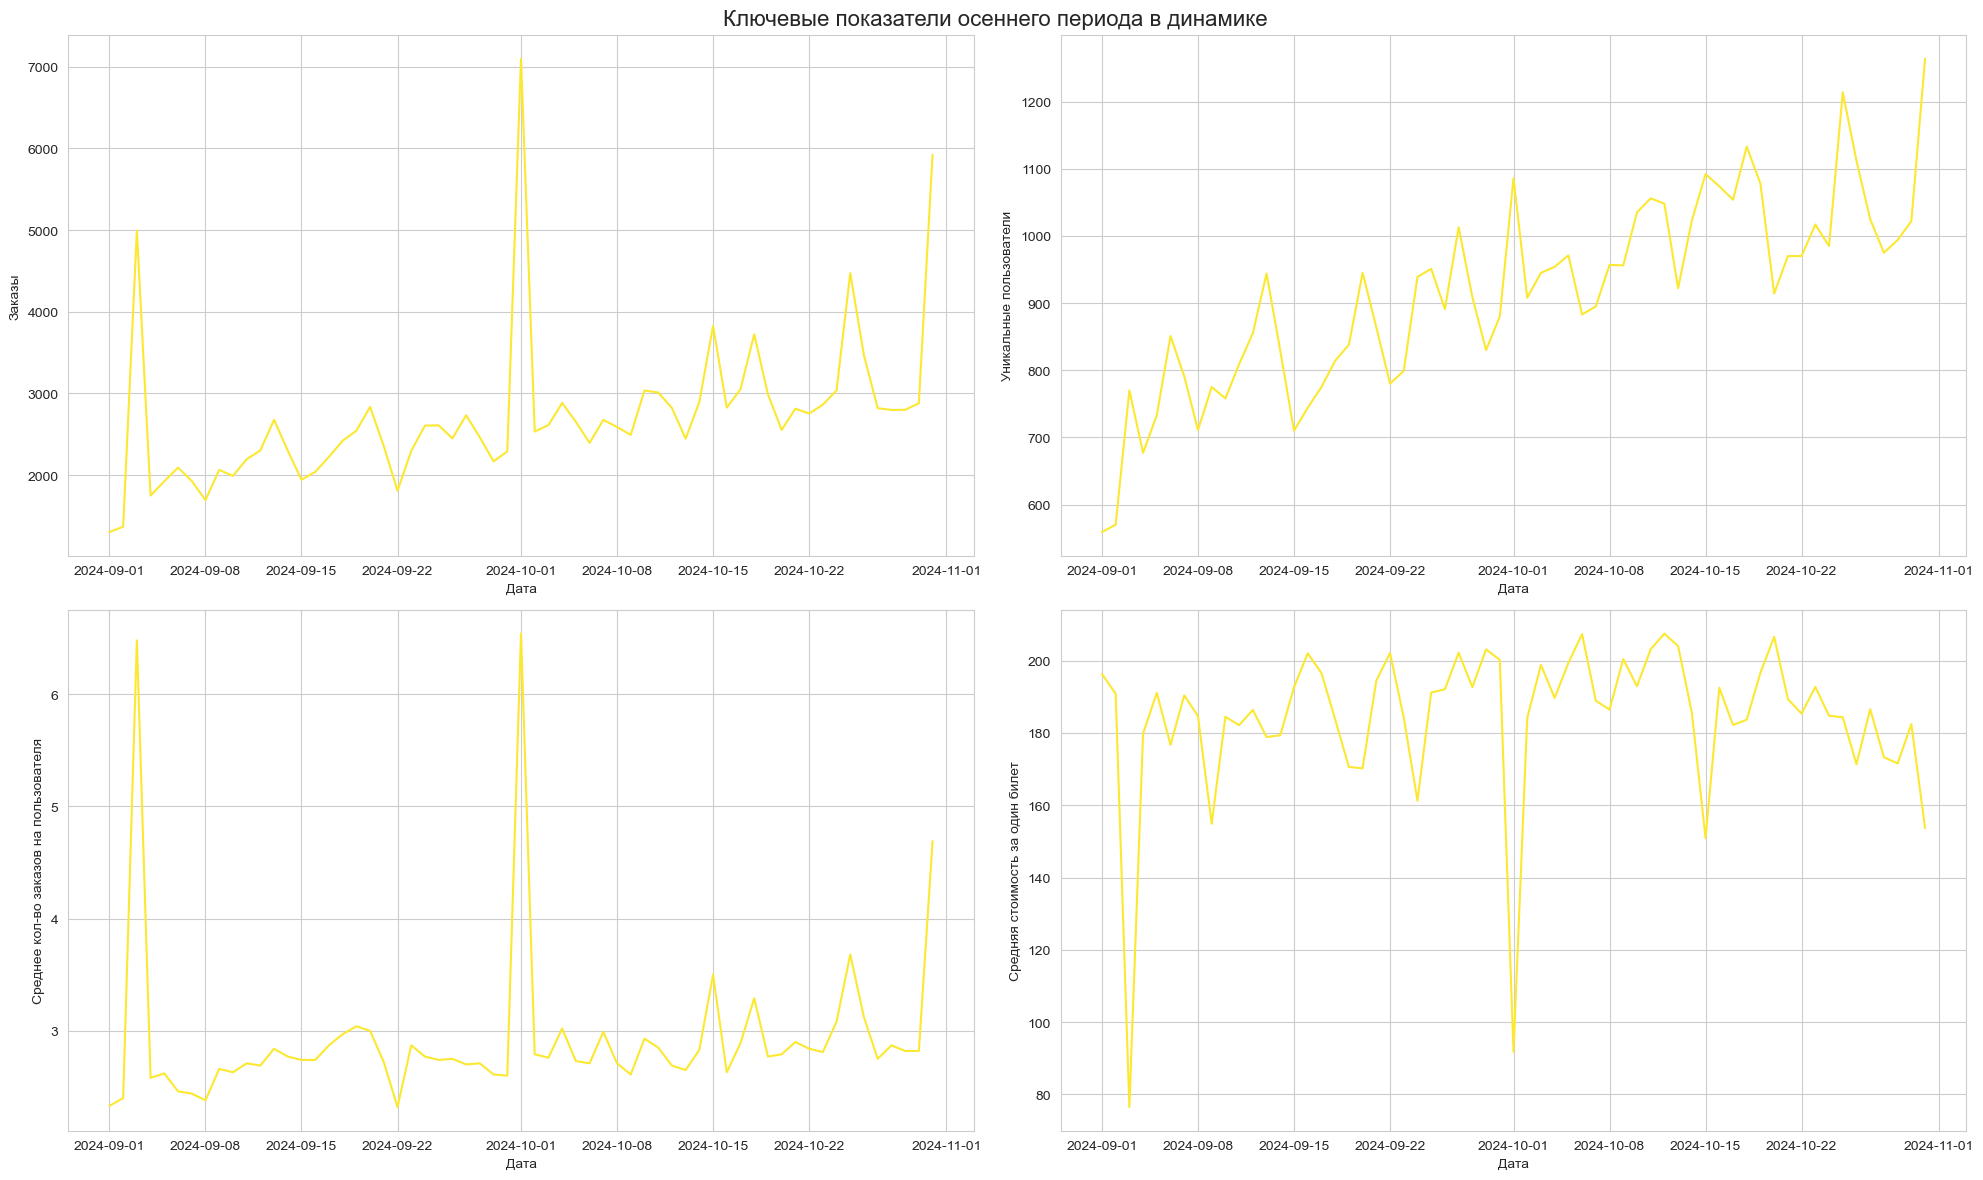

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

sns.lineplot(data=df_autumn_grouped, x='created_dt_msk', y='orders', color='#fce830', ax=axes[0])
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Заказы')

sns.lineplot(data=df_autumn_grouped, x='created_dt_msk', y='dau', color='#fce830', ax=axes[1])
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Уникальные пользователи')

sns.lineplot(data=df_autumn_grouped, x='created_dt_msk', y='avg_orders_per_user', color='#fce830', ax=axes[2])
axes[2].set_xlabel('Дата')
axes[2].set_ylabel('Среднее кол-во заказов на пользователя')

sns.lineplot(data=df_autumn_grouped, x='created_dt_msk', y='avg_revenue_per_ticket', color='#fce830', ax=axes[3])
axes[3].set_xlabel('Дата')
axes[3].set_ylabel('Средняя стоимость за один билет')

fig.suptitle('Ключевые показатели осеннего периода в динамике', fontsize=16)
plt.tight_layout()
plt.show()

- По заказам видны свечки 03.09.2024, 01.10.2024, 31.10.2024, возможно в этот период были какие-то акции (что-то типа в первый и последний день "3 билета по цене 2") и это при том, что уникальных посетителей было столько же или примерно столько же
- Устойчивый тренд на увеличение количества уникальных посетителей на площадке
- Свечки в среднем количестве заказов на пользователяи и средней стоимости за билет совпадают со свечками по количеству заказов, только для стоимости билета обратная зависимость, чем больше заказов сделано - тем меньше стоимость одного билета

Теперь сравним эти метрики в разрезе будних и выходных дней

In [36]:
# выделим номер дня недели
df_autumn_grouped['day_of_week'] = df_autumn_grouped['created_dt_msk'].dt.dayofweek

# функция для определения типа дня: будний или выходной
def type_of_day(day_of_week):
    if day_of_week < 5:
        return 'будни'
    else:
        return 'выходные'

# используем функцию
df_autumn_grouped['type_of_day'] = df_autumn_grouped['day_of_week'].apply(type_of_day)

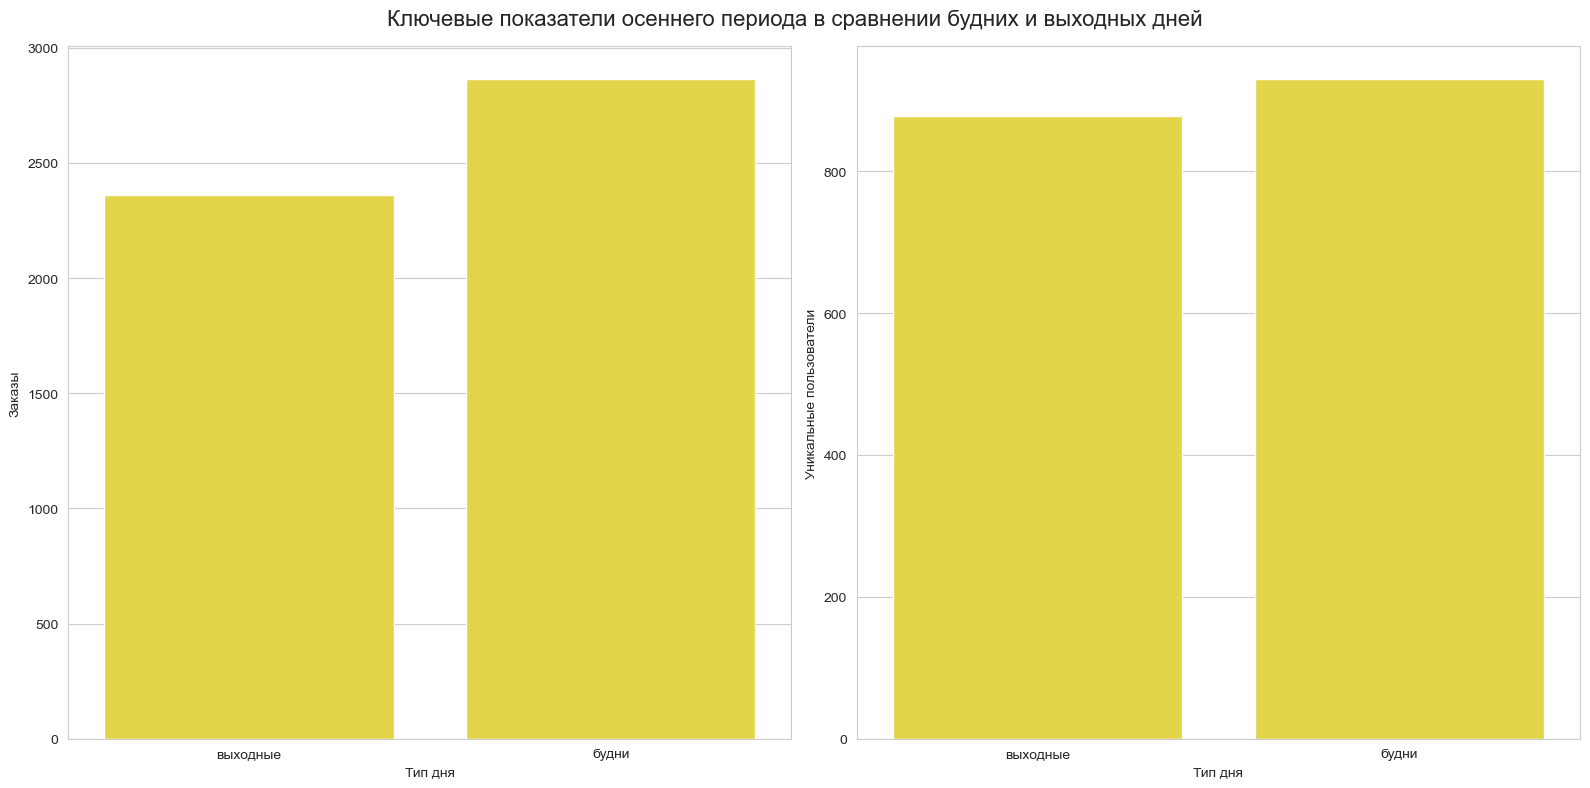

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(data=df_autumn_grouped, x='type_of_day', y='orders', color='#fce830', ax=axes[0], ci=None)
axes[0].set_xlabel('Тип дня')
axes[0].set_ylabel('Заказы')

sns.barplot(data=df_autumn_grouped, x='type_of_day', y='dau', color='#fce830', ax=axes[1], ci=None)
axes[1].set_xlabel('Тип дня')
axes[1].set_ylabel('Уникальные пользователи')

fig.suptitle('Ключевые показатели осеннего периода в сравнении будних и выходных дней', fontsize=16)
plt.tight_layout()
plt.show()

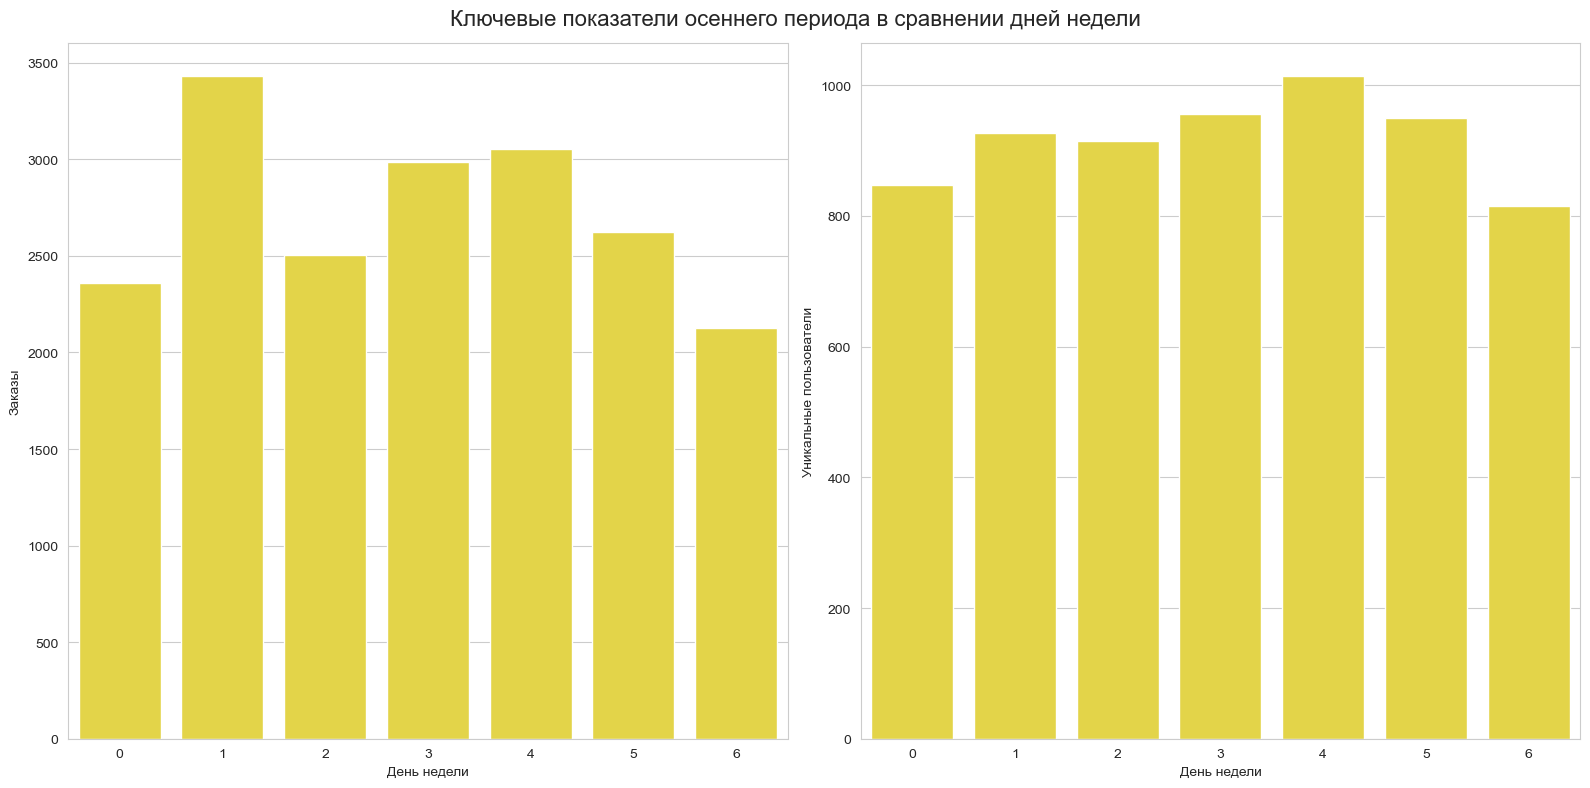

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(data=df_autumn_grouped, x='day_of_week', y='orders', color='#fce830', ax=axes[0], ci=None)
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Заказы')

sns.barplot(data=df_autumn_grouped, x='day_of_week', y='dau', color='#fce830', ax=axes[1], ci=None)
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Уникальные пользователи')

fig.suptitle('Ключевые показатели осеннего периода в сравнении дней недели', fontsize=16)
plt.tight_layout()
plt.show()

В будни совершается больше заказов, чем в выходные. Так же как и пользователи больше заходят в сервис в будни. Это может быть обусловлено тем, что все мероприятия обычно проходят в выходные, а чтобы успеть купить билеты на них, необходимо зайти в приложение именно в будни.

Больше всего заказов совершается во вторник, далее в четверг и среду, вероятно в начале и конце недели пользователям вообще не до покупки билетов - прийти бы в себя после субботы и понедельника. По уникальным пользователям примерно такая же динамика, только самый посещаемый день - четверг, остальные же дни плюс-минус в одном диапазоне. Воскресенье и понедельник при этом опять в отстающих.

### Популярные события и партнёры

Исследуем, какие регионы имеют наибольшее количество уникальных мероприятий и количество заказов, а также вычислим долю для этих показателей.

In [39]:
# группируем и подсчитываем данные по мероприятиям и заказам
df_regions = df_autumn.groupby('region_name', as_index=False).agg(
    unique_events=('event_id', 'nunique'),
    orders=('order_id', 'count')
)

# считаем общие суммы
df_regions['total_events'] = df_regions['unique_events'].sum()
df_regions['total_orders'] = df_regions['orders'].sum()

# вычисляем долю
df_regions['share_events'] = df_regions['unique_events'] / df_regions['total_events']
df_regions['share_orders'] = df_regions['orders'] / df_regions['total_orders']

# оставляем только топ-5
df_regions = df_regions.sort_values(by=['share_events', 'share_orders'], ascending=False).head(5)

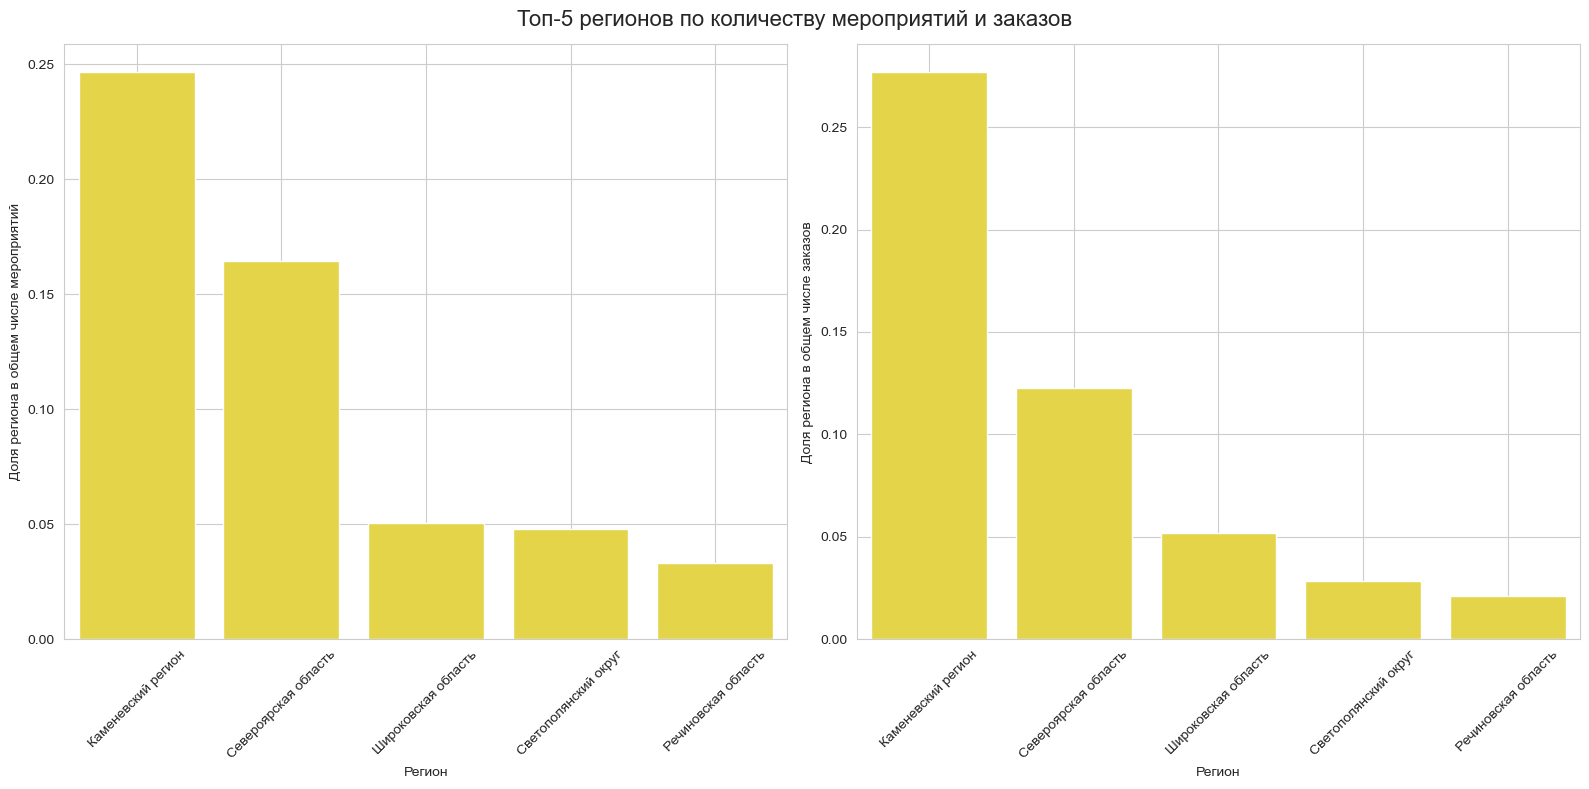

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(data=df_regions, x='region_name', y='share_events', color='#fce830', ax=axes[0], ci=None)
axes[0].set_xlabel('Регион')
axes[0].set_ylabel('Доля региона в общем числе мероприятий')

sns.barplot(data=df_regions, x='region_name', y='share_orders', color='#fce830', ax=axes[1], ci=None)
axes[1].set_xlabel('Регион')
axes[1].set_ylabel('Доля региона в общем числе заказов')

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(True)

fig.suptitle('Топ-5 регионов по количеству мероприятий и заказов', fontsize=16)
plt.tight_layout()
plt.show()

Безусловный лидер по заказам и разнообразию мероприятий - Каменевский регион, примерно 24% мероприятий и 27% заказов приходится именно на него. Далее идет Североярская область, но доля мероприятий тут уже ниже, примерно 17% и 13% заказов. Далее все остальные региноы значительно отстают от упомянутых выше, их доли меньше 5%.

Перейдем к анализу партнеров:

In [41]:
# группируем и подсчитываем данные по мероприятиям и заказам
df_partners = df_autumn.groupby('service_name', as_index=False).agg(
    unique_events=('event_id', 'nunique'),
    orders=('order_id', 'count'),
    revenue=('revenue', 'sum')
)

# считаем общие суммы
df_partners['total_events'] = df_partners['unique_events'].sum()
df_partners['total_orders'] = df_partners['orders'].sum()
df_partners['total_revenue'] = df_partners['revenue'].sum()

# вычисляем долю
df_partners['share_events'] = df_partners['unique_events'] / df_partners['total_events']
df_partners['share_orders'] = df_partners['orders'] / df_partners['total_orders']
df_partners['share_revenue'] = df_partners['revenue'] / df_partners['total_revenue']

# оставляем только топ-10
df_partners = df_partners.sort_values(by=['share_revenue','share_events', 'share_orders'], ascending=False).head(10)

# здесь просто выведу датафрейм, потому что показателей много и визуализация будет излишней и малопонятной 
display(df_partners[['service_name', 'share_revenue', 'share_orders', 'share_events']])

,service_name,share_revenue,share_orders,share_events
3,Билеты без проблем,0.160650,0.191632,0.164430
24,Мой билет,0.137728,0.115408,0.057928
25,Облачко,0.127410,0.092387,0.081401
21,Лови билет!,0.123415,0.152954,0.209110
8,Весь в билетах,0.111452,0.055943,0.034629
5,Билеты в руки,0.090020,0.152057,0.142816
19,Край билетов,0.035835,0.017752,0.011214
34,Яблоко,0.032959,0.020613,0.031085
26,Прачечная,0.030164,0.034216,0.042240
30,Тебе билет!,0.025527,0.022227,0.049503


Самую большую долю выручки имеет партнер "Билеты без проблем", также он лидер и по заказам, по разнообразию мероприятий он на втором месте. Далее идет "Мой билет", малое количество мероприятий относительно других лидеров говорит о том, что оператор предлагает ограниченный пул мероприятий, но такой, что занимает 2ое место по выручке - возможно у него популярнее мероприятия. Оператор "Облачко" явно имеет средний чек выше, чем у других операторов, так как у него 3е место по выручке, но относительно скромная доля заказов.

**Промежуточные выводы по исследовательскому анализу данных**
- Общая динамика по заказам действительно показывает, что к октябрю значительно увеличились заказы - на 190%
- Все события кроме спорта и концертов, упали в долевом отношении заказов, начали расти елки
- По типам устройств все стабильно, лишь небольшое изменение, увеличились заказы со стационарных устройств на 1%, а с мобильных соответственно уменьшились на 1%
- В возрастных ограничениях доли снизились у всех, кроме категорий 0 и 12 лет, что говорит о смешающемся спросе в сторону детских и подростковых мероприятий
- Осенью практически по всем типам событий (кроме стэндапов и выставок) было зафиксировано снижение стоимости одного билета, что предположительно может быть связано с акциями в придверии сезона или же потребительскими предпочтениями, смещением их интереса в сторону более дешевых билетов
- Активность пользователей осенью увеличилась по сравнению с активностью летом, было несколько пиков по заказам, что похоже на проведение каких-то промоакций
- Чаще всего заказы оформляют в будни, потому что скорее всего все мероприятия проходят в выходные, а билеты нужно покупать заранее. По посещениям дни-лидеры - вторник и четверг, по заказам - четверг (возможно к четвергу пользователь как раз созревает для заказа)
- Были выделены регионы-лидеры, которые имели наибольшее количество разнообразных мероприятий и высокую выручку - это Каменевский регион с большим отрывом, Североярская область, а также Широковская область
- Среди партнеров выделяются операторы Билеты без проблем, Мой билет, Облачко.

## Статистический анализ данных

Команда продукта заинтересована в проверке следующих гипотез:
- **Среднее количество заказов на одного пользователя мобильного приложения выше** по сравнению с пользователями стационарных устройств;
- **Среднее время между заказами пользователей мобильных приложений выше** по сравнению с пользователями стационарных устройств.

Для тестирования гипотез необходимо провести проверку данных, предварительная проверка будет включать в себя:
- пересечения в группах, очистка групп при необходимости
- подбор теста (с опорой на распределение в выборках)
- формулирование нулевой и альтернативной гипотез и проведение теста

Начнем с проверки на пересечения в группах

In [42]:
desktop_group_users = df_autumn[df_autumn['device_type_canonical'] == 'desktop']['user_id']
mobile_group_users = df_autumn[df_autumn['device_type_canonical'] == 'mobile']['user_id']

intersection = list(set(desktop_group_users) & set(mobile_group_users))
print(f'Размер группы стационарных устройств - {desktop_group_users.nunique()}, мобильных устройств - {mobile_group_users.nunique()}')
print(f'Пересечения в группах: {len(intersection)}')

Размер группы стационарных устройств - 4826, мобильных устройств - 14095
Пересечения в группах: 3216


В группах есть пересечения, а также пользователей стационарных устройств значительно меньше, чем пользователей мобильных устройств, тем более после очистки групп их станет еще меньше. Уже при таком условии есть предпосылка использовать тест Манна-Уитни (а также при том условии, что у нас данные распределены ненормально, что мы тоже далее проверим). А пока избавимся от пользователей, которые есть в обеих группах:

In [43]:
desktop_group_users = desktop_group_users[~desktop_group_users.isin(intersection)]
mobile_group_users = mobile_group_users[~mobile_group_users.isin(intersection)]

print(f'Итоговый размер группы стационарных устройств - {desktop_group_users.nunique()}, мобильных устройств - {mobile_group_users.nunique()}')

Итоговый размер группы стационарных устройств - 1610, мобильных устройств - 10879


Размеры групп после исключения пересечений сошлись, очистка прошла успешно. Теперь сформируем данные для тестирования первой гипотезы и посмотрим на распределение этих данных.

### Проверка гипотезы о равенстве среднего количества заказов различных устройств

Теперь сформируем данные для тестирования первой гипотезы и посмотрим на распределение этих данных.

In [44]:
desktop_group_1 = df_autumn[df_autumn['user_id'].isin(desktop_group_users)].groupby('user_id', as_index=False).agg({'order_id': 'nunique'})
mobile_group_1 = df_autumn[df_autumn['user_id'].isin(mobile_group_users)].groupby('user_id', as_index=False).agg({'order_id': 'nunique'})

print(desktop_group_1.describe(percentiles=[.95, .99]))
print(mobile_group_1.describe(percentiles=[.95, .99]))

          order_id
count  1610.000000
mean      1.963354
std       3.042769
min       1.000000
50%       1.000000
95%       5.000000
99%      12.000000
max      56.000000
           order_id
count  10879.000000
mean       2.840794
std        4.037449
min        1.000000
50%        2.000000
95%        9.000000
99%       19.000000
max      123.000000


Данные имеют выбросы, явно скошенны влево.

Формулируем нулевую и альтернативную гипотезы для теста:
- Н0: Среднее количество заказов на пользователя мобильных устройств **не выше** среднего количества заказов стационарных устройств
- Н1: Среднее количество заказов на пользователя мобильных устройств **выше** среднего количества заказов стационарных устройств

Проведем статистический тест

In [45]:
alpha = 0.05

stat_test, p_value_mannwhitneyu = mannwhitneyu(
    mobile_group_1['order_id'],
    desktop_group_1['order_id'],
    alternative='greater'
)

if p_value_mannwhitneyu > alpha:
    print(f'{p_value_mannwhitneyu=:.7f}. Нулевая гипотеза не отвергается')
else:
    print(f'{p_value_mannwhitneyu=:.7f}. Принимаем альтернативную гипотезу')

p_value_mannwhitneyu=0.0000000. Принимаем альтернативную гипотезу


Результат теста говорит о том, что у нас есть основания предполагать, что пользователи мобильных устройств покупают билетов больше.

### Проверка гипотезы о равенстве среднего количества заказов различных устройств

Для этой гипотезы нам тоже нужно предварительно сформировать выборки данных с непересекающимися пользователями и отфильтровать пропуски в столбце `days_since_prev`.

In [46]:
desktop_group_2 = df_autumn[(df_autumn['user_id'].isin(desktop_group_users)) & (~df_autumn['days_since_prev'].isna())]
mobile_group_2 = df_autumn[(df_autumn['user_id'].isin(mobile_group_users)) & (~df_autumn['days_since_prev'].isna())]

print(desktop_group_2['days_since_prev'].describe())
print(mobile_group_2['days_since_prev'].describe())

count       2063.0
mean     18.083858
std       32.69017
min            0.0
25%            0.0
50%            0.0
75%           22.0
max          146.0
Name: days_since_prev, dtype: Float64
count      24307.0
mean     13.792035
std      25.699062
min            0.0
25%            0.0
50%            1.0
75%           15.0
max          148.0
Name: days_since_prev, dtype: Float64


Данные имеют выбросы, явно скошенны влево.

Формулируем нулевую и альтернативную гипотезы для теста:
- Н0: Среднее время между заказами пользователей мобильных приложений **не выше** по сравнению с пользователями стационарных устройств
- Н1: Среднее время между заказами пользователей мобильных приложений **выше** по сравнению с пользователями стационарных устройств

Проведем статистический тест

In [47]:
alpha = 0.05

stat_test, p_value_mannwhitneyu = mannwhitneyu(
    mobile_group_2['days_since_prev'],
    desktop_group_2['days_since_prev'],
    alternative='greater'
)

if p_value_mannwhitneyu > alpha:
    print(f'{p_value_mannwhitneyu=:.7f}. Нулевая гипотеза не отвергается')
else:
    print(f'{p_value_mannwhitneyu=:.7f}. Принимаем альтернативную гипотезу')

p_value_mannwhitneyu=0.0000001. Принимаем альтернативную гипотезу


Здесь результат теста говорит нам о том, что среднее время между заказами у пользователей мобильных утсройств все-таки выше, чем у пользователей стационарных устройств. Возможно это связано с тем, что они покупают больше, но реже

## Итоговый вывод и рекомендации

Для исследования были предоставлены данные сервиса Яндекс.Афиша за период 01.06.2024-31.10.2024. 
В данных были выявлены пропуски при объединении двух датафреймов, аномалии в количественных столбцах, а также неявные дубликаты. После предобработки данные сократились на 2.5%, а итоговый объем результатирующего датафрейма составил - 283 395 строк. Для команды продукта инсайт по поводу определения типа события и описания события - значения "другое" и "события" убрать из классификации мероприятий, чтобы точно идентифицировать информацию и не терять огромные куски данных при анализе.

**В ходе исследовательского анализа данных были сформулированы следующие выводы:**
- Увеличение пользователськой активности действительно наблюдается в сентябре и октябре, что обусловлено тем, что в осеннюю погоду меньше возможностей проведения досуга, на улице уже холодает, а также большинство людей вероятно возвращается из отпусков;
- Особый интерес осенью также наблюдается к таким типам событий, как "спорт" и "театр", а также уже виден интерес к "елкам", остальные же типы событий в сравнении с летом наоборот теряют в популярности;
- Средняя стоимость билетов практически по всем типам событий снижается осенью, а также видно, что в начале осенних месяцев есть пики по заказам (при том, что такого же значительного увеличения притока пользователей нет, значит что-то происходит с конверсионностью), нужно понять, в чем их причина, разобраться глубже с проводимыми акциями и тестами;
- Больше заказов совершается в будни, а именно в четверг, а посещаемость также высокая именно в будни - вторник, четверг, среду. Можно предположить, что вторник, среду пользователи присматриваются, а в четверг уже делают заказ;
- Среди регионов есть яркие лидеры по выручке и заказам, это Каменевский регион и Североярская область, далее остальные регионы уже составляют не такую большую долю, эти регионы можно назвать некими монополистами или олигополистами (по крайней мере из всех они наиболее консолидированы, у остальных малые доли);
- Среди партнеров лидеры - Билеты без проблем, Мой билет, Облачко. "Мой билет" имеет малое количество мероприятий относительно других лидеров, это говорит о том, что оператор предлагает ограниченный пул мероприятий, но такой, что занимает 2ое место по выручке - возможно у него популярнее мероприятия. Оператор "Облачко" явно имеет средний чек выше, чем у других операторов, так как у него 3е место по выручке, но относительно скромная доля заказов.

**Выводы по статистическому анализу и проверке гипотез:**
- Пользователи мобильных устройств приобретают больше билетов, но реже. Есть основания для того, чтобы эти сегменты уравнять - интенсифицировать частоту покупок у пользователей мобильных устройств, а у стационарных количество приобретаемых билетов.

**Практические рекомендации:**
- При годовом планировании стоит учитывать сезонность и в связи с этим распределять бюджеты в пиковые периоды - сентябрь-декабрь. Что касается более коротких горизонтов планирования, то промоакции, пуш-уведомления, e-mail-рассылки следует делать со вторника по четверг, вторник-среда - более информационный контент, а в четверг - конверсионный (скидки, акции и тд.). Либо же можно стимулировать продажи в другие дни, отличные от четверга, типа "ранний билет" - приобретай билет до четверга и получай скидку 10%
- Концентрация на интересных для текущего сезона типа событий - театры, спорт и елки. Тоже планирование под них выдачу, плейсменты, акции и бюджеты.
- Развивать больше регионов, потому что два ведущих региона это очень мало, явно есть потенциал для роста, по приоритету взять следующие по выручке регионы - Широковская область, Светополянский округ, Речиновская область. Рассмотреть различные сотрудничества с местными операторами и площадками.
- Для различных типов устройств две различные стратегии - для пользователей мобильных устройств увеличить частоту покупок (сократить срок именно между заказами), а для десктопных пользователей увеличить количество билетов в заказе (увеличение среднего чека)